In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
master_path = '/content/gdrive/My Drive/Colab Notebooks/'
folder = 'Project/Clothes/'

Mounted at /content/gdrive


In [ ]:
# Import bounding boxes to dictionary

d = {}
with open(master_path+"/Project/list_bbox.txt") as f:
  for i, line in enumerate(f):
    if i != 0 and i != 1: # ignore first two lines
      (key, x1, y1, x2, y2) = line.split()

      #if "Acid_Wash_Ankle_Jeans" in key or "Athletic_Marled_Knit_Joggers" in key or "Basic_Crew_Neck_Tee" in key or "Button_Fly_Denim_Shorts" in key or "Contrast-Trimmed_Sweater" in key: # space saver for now...
      d[key] = (int(x1), int(y1), int(x2), int(y2))

print(len(d))

289222


In [ ]:
#transform = transforms.Compose([transforms.ToTensor()])
#dataset = torchvision.datasets.ImageFolder(root=master_path+folder, transform=transform)

In [ ]:
# Need to overwrite default ImageFolder method in torchvision so that we can preserve the filename of the samples

from torchvision import datasets
class ImageFolderWithPaths(datasets.ImageFolder): # https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

# instantiate the dataset and dataloader
transform = transforms.Compose([transforms.ToTensor()])
dataset = ImageFolderWithPaths(root=master_path+folder, transform=transform) # our custom dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

In [ ]:
max = 0

for data in dataloader:
  h = data[0].shape[2]
  w = data[0].shape[3]
  if h > max:
    max = h
  if w > max:
    max = w

print(max)

301


In [ ]:
def crop_image(img, filename, max_size):
  
  print("Original shape:", img.shape)
  img = img.permute(1, 2, 0) # rearrange tensor so colour channel is at the end
  print("RGB channel moved:", img.shape)

  print("Name:", filename)

  # in bbox file, filenames are formatted like this: img/Sheer_Pleated-Front_Blouse/img_00000001.jpg
  filename = "img/" + filename[59:] # get rid of google drive prefix and replace with "img/"
  print("Modified name:", filename)

  img_name = filename
  x1, y1, x2, y2 = d[img_name] # get bbox values

  img_cropped = img[y1:y2, x1:x2, :3] # crop based on bbox values

  print("Cropped shape:", img_cropped.shape)

  # create background image for uniformly-sized images
  bg = torch.zeros((max_size,max_size,3))

  # superimpose cropped image on background
  for z in range(img_cropped.shape[2]):
    for y in range(img_cropped.shape[1]):
      for x in range(img_cropped.shape[0]):
        bg[x][y][z] = img_cropped[x][y][z]

  # plot original and bounded side by side
  f = plt.figure()
  f.add_subplot(1,3, 1)
  plt.imshow(img)
  f.add_subplot(1,3, 2)
  plt.imshow(img_cropped)
  f.add_subplot(1,3, 3)
  plt.imshow(bg)
  plt.show(block=True)

  return bg

Original shape: torch.Size([3, 300, 205])
RGB channel moved: torch.Size([300, 205, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/3_Athletic_Marled_Knit_Joggers/img_00000002.jpg
Modified name: img/Athletic_Marled_Knit_Joggers/img_00000002.jpg
Cropped shape: torch.Size([177, 59, 3])


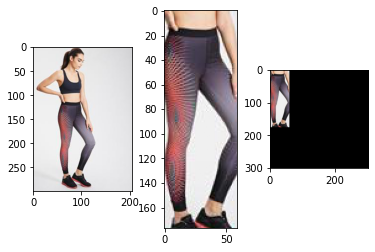

Original shape: torch.Size([3, 300, 179])
RGB channel moved: torch.Size([300, 179, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/0_Basic_Crew_Neck_Tee/img_00000007.jpg
Modified name: img/Basic_Crew_Neck_Tee/img_00000007.jpg
Cropped shape: torch.Size([226, 157, 3])


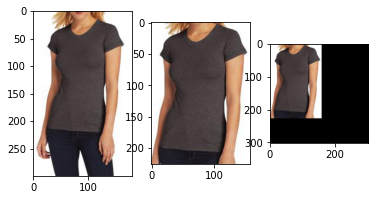

Original shape: torch.Size([3, 300, 300])
RGB channel moved: torch.Size([300, 300, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/0_Basic_Crew_Neck_Tee/img_00000006.jpg
Modified name: img/Basic_Crew_Neck_Tee/img_00000006.jpg
Cropped shape: torch.Size([265, 240, 3])


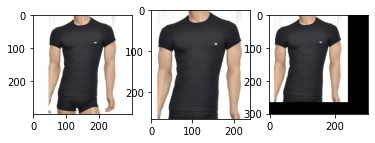

Original shape: torch.Size([3, 300, 210])
RGB channel moved: torch.Size([300, 210, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/6_Boxy_Turtleneck_Sweater/img_00000063.jpg
Modified name: img/Boxy_Turtleneck_Sweater/img_00000063.jpg
Cropped shape: torch.Size([215, 170, 3])


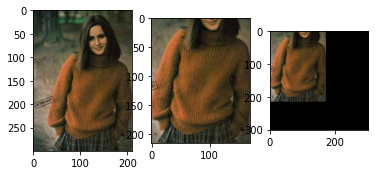

Original shape: torch.Size([3, 300, 300])
RGB channel moved: torch.Size([300, 300, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/5_Box-Pleated_A-Line_Skirt/img_00000002.jpg
Modified name: img/Box-Pleated_A-Line_Skirt/img_00000002.jpg
Cropped shape: torch.Size([215, 276, 3])


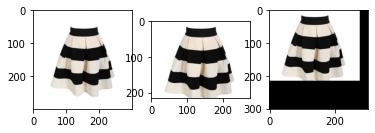

Original shape: torch.Size([3, 301, 205])
RGB channel moved: torch.Size([301, 205, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/2_Acid_Wash_Ankle_Jeans/img_00000005.jpg
Modified name: img/Acid_Wash_Ankle_Jeans/img_00000005.jpg
Cropped shape: torch.Size([161, 72, 3])


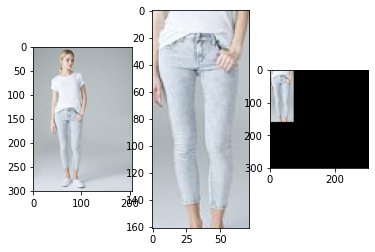

Original shape: torch.Size([3, 300, 300])
RGB channel moved: torch.Size([300, 300, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/4_Button_Fly_Denim_Shorts/img_00000002.jpg
Modified name: img/Button_Fly_Denim_Shorts/img_00000002.jpg
Cropped shape: torch.Size([197, 287, 3])


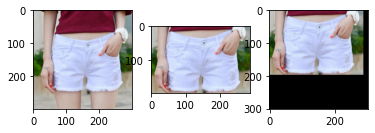

Original shape: torch.Size([3, 300, 135])
RGB channel moved: torch.Size([300, 135, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/8_Classic_Double-Breasted_Trench_Coat/img_00000016.jpg
Modified name: img/Classic_Double-Breasted_Trench_Coat/img_00000016.jpg
Cropped shape: torch.Size([235, 133, 3])


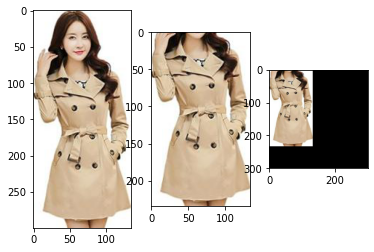

Original shape: torch.Size([3, 301, 200])
RGB channel moved: torch.Size([301, 200, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/1_Contrast-Trimmed_Sweater/img_00000007.jpg
Modified name: img/Contrast-Trimmed_Sweater/img_00000007.jpg
Cropped shape: torch.Size([201, 193, 3])


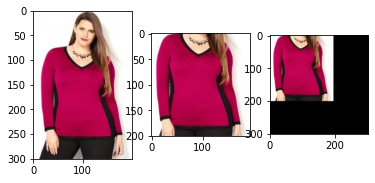

Original shape: torch.Size([3, 300, 240])
RGB channel moved: torch.Size([300, 240, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/5_Box-Pleated_A-Line_Skirt/img_00000014.jpg
Modified name: img/Box-Pleated_A-Line_Skirt/img_00000014.jpg
Cropped shape: torch.Size([136, 185, 3])


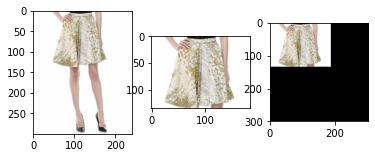

Original shape: torch.Size([3, 300, 300])
RGB channel moved: torch.Size([300, 300, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/7_Abstract_Print_Pleated_Dress/img_00000040.jpg
Modified name: img/Abstract_Print_Pleated_Dress/img_00000040.jpg
Cropped shape: torch.Size([161, 102, 3])


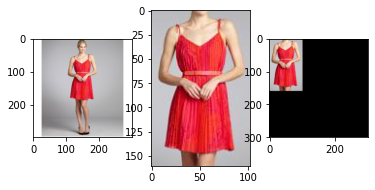

Original shape: torch.Size([3, 300, 263])
RGB channel moved: torch.Size([300, 263, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/1_Contrast-Trimmed_Sweater/img_00000003.jpg
Modified name: img/Contrast-Trimmed_Sweater/img_00000003.jpg
Cropped shape: torch.Size([106, 94, 3])


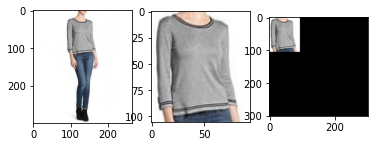

Original shape: torch.Size([3, 300, 236])
RGB channel moved: torch.Size([300, 236, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/1_Contrast-Trimmed_Sweater/img_00000004.jpg
Modified name: img/Contrast-Trimmed_Sweater/img_00000004.jpg
Cropped shape: torch.Size([244, 168, 3])


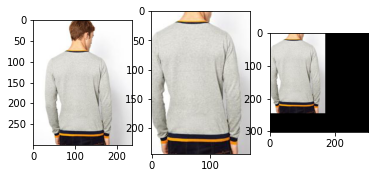

Original shape: torch.Size([3, 300, 205])
RGB channel moved: torch.Size([300, 205, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/3_Athletic_Marled_Knit_Joggers/img_00000008.jpg
Modified name: img/Athletic_Marled_Knit_Joggers/img_00000008.jpg
Cropped shape: torch.Size([197, 70, 3])


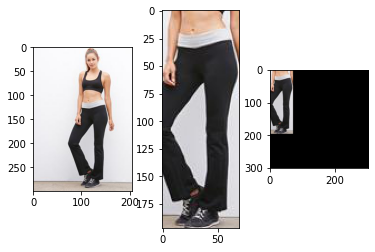

Original shape: torch.Size([3, 300, 161])
RGB channel moved: torch.Size([300, 161, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/8_Classic_Double-Breasted_Trench_Coat/img_00000039.jpg
Modified name: img/Classic_Double-Breasted_Trench_Coat/img_00000039.jpg
Cropped shape: torch.Size([275, 144, 3])


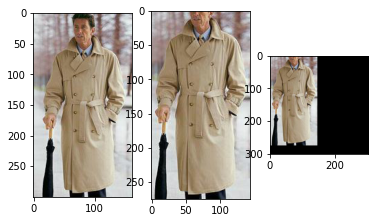

Original shape: torch.Size([3, 300, 205])
RGB channel moved: torch.Size([300, 205, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/5_Box-Pleated_A-Line_Skirt/img_00000011.jpg
Modified name: img/Box-Pleated_A-Line_Skirt/img_00000011.jpg
Cropped shape: torch.Size([177, 151, 3])


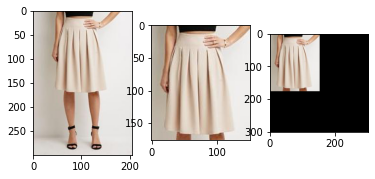

Original shape: torch.Size([3, 250, 200])
RGB channel moved: torch.Size([250, 200, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/2_Acid_Wash_Ankle_Jeans/img_00000002.jpg
Modified name: img/Acid_Wash_Ankle_Jeans/img_00000002.jpg
Cropped shape: torch.Size([249, 109, 3])


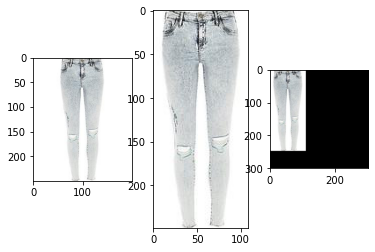

Original shape: torch.Size([3, 300, 237])
RGB channel moved: torch.Size([300, 237, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/0_Basic_Crew_Neck_Tee/img_00000009.jpg
Modified name: img/Basic_Crew_Neck_Tee/img_00000009.jpg
Cropped shape: torch.Size([270, 235, 3])


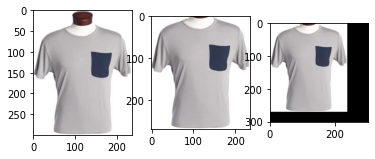

Original shape: torch.Size([3, 300, 199])
RGB channel moved: torch.Size([300, 199, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/6_Boxy_Turtleneck_Sweater/img_00000070.jpg
Modified name: img/Boxy_Turtleneck_Sweater/img_00000070.jpg
Cropped shape: torch.Size([166, 156, 3])


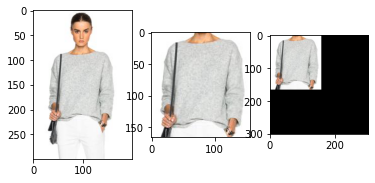

Original shape: torch.Size([3, 301, 301])
RGB channel moved: torch.Size([301, 301, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/4_Button_Fly_Denim_Shorts/img_00000006.jpg
Modified name: img/Button_Fly_Denim_Shorts/img_00000006.jpg
Cropped shape: torch.Size([151, 224, 3])


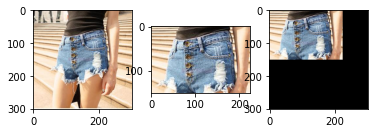

Original shape: torch.Size([3, 300, 300])
RGB channel moved: torch.Size([300, 300, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/4_Button_Fly_Denim_Shorts/img_00000001.jpg
Modified name: img/Button_Fly_Denim_Shorts/img_00000001.jpg
Cropped shape: torch.Size([89, 122, 3])


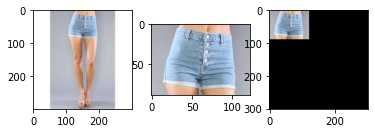

Original shape: torch.Size([3, 301, 205])
RGB channel moved: torch.Size([301, 205, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/3_Athletic_Marled_Knit_Joggers/img_00000001.jpg
Modified name: img/Athletic_Marled_Knit_Joggers/img_00000001.jpg
Cropped shape: torch.Size([139, 98, 3])


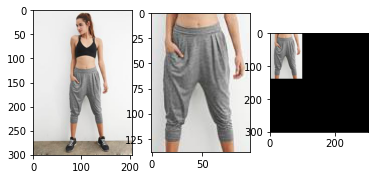

Original shape: torch.Size([3, 300, 300])
RGB channel moved: torch.Size([300, 300, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/6_Boxy_Turtleneck_Sweater/img_00000012.jpg
Modified name: img/Boxy_Turtleneck_Sweater/img_00000012.jpg
Cropped shape: torch.Size([242, 142, 3])


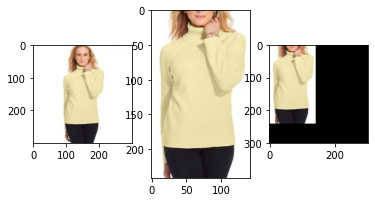

Original shape: torch.Size([3, 300, 300])
RGB channel moved: torch.Size([300, 300, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/6_Boxy_Turtleneck_Sweater/img_00000076.jpg
Modified name: img/Boxy_Turtleneck_Sweater/img_00000076.jpg
Cropped shape: torch.Size([240, 158, 3])


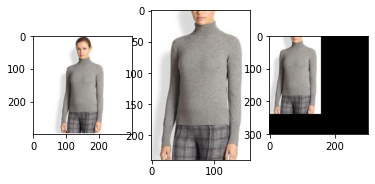

Original shape: torch.Size([3, 300, 300])
RGB channel moved: torch.Size([300, 300, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/7_Abstract_Print_Pleated_Dress/img_00000048.jpg
Modified name: img/Abstract_Print_Pleated_Dress/img_00000048.jpg
Cropped shape: torch.Size([213, 173, 3])


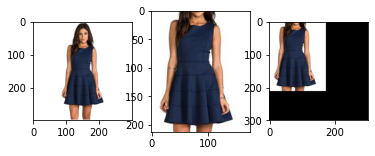

Original shape: torch.Size([3, 300, 205])
RGB channel moved: torch.Size([300, 205, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/6_Boxy_Turtleneck_Sweater/img_00000024.jpg
Modified name: img/Boxy_Turtleneck_Sweater/img_00000024.jpg
Cropped shape: torch.Size([216, 134, 3])


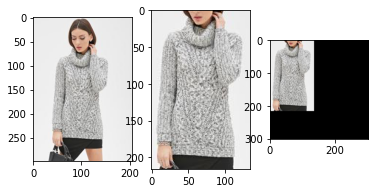

Original shape: torch.Size([3, 300, 236])
RGB channel moved: torch.Size([300, 236, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/0_Basic_Crew_Neck_Tee/img_00000003.jpg
Modified name: img/Basic_Crew_Neck_Tee/img_00000003.jpg
Cropped shape: torch.Size([270, 234, 3])


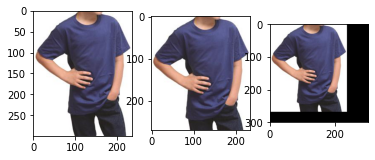

Original shape: torch.Size([3, 300, 300])
RGB channel moved: torch.Size([300, 300, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/3_Athletic_Marled_Knit_Joggers/img_00000006.jpg
Modified name: img/Athletic_Marled_Knit_Joggers/img_00000006.jpg
Cropped shape: torch.Size([196, 65, 3])


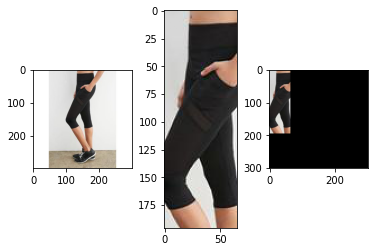

Original shape: torch.Size([3, 300, 200])
RGB channel moved: torch.Size([300, 200, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/8_Classic_Double-Breasted_Trench_Coat/img_00000021.jpg
Modified name: img/Classic_Double-Breasted_Trench_Coat/img_00000021.jpg
Cropped shape: torch.Size([233, 167, 3])


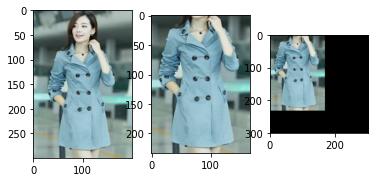

Original shape: torch.Size([3, 300, 211])
RGB channel moved: torch.Size([300, 211, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/2_Acid_Wash_Ankle_Jeans/img_00000001.jpg
Modified name: img/Acid_Wash_Ankle_Jeans/img_00000001.jpg
Cropped shape: torch.Size([207, 52, 3])


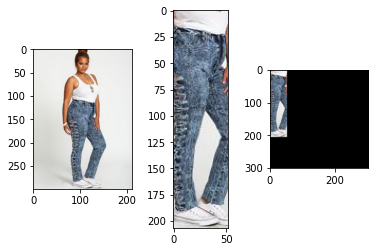

Original shape: torch.Size([3, 250, 200])
RGB channel moved: torch.Size([250, 200, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/1_Contrast-Trimmed_Sweater/img_00000010.jpg
Modified name: img/Contrast-Trimmed_Sweater/img_00000010.jpg
Cropped shape: torch.Size([113, 91, 3])


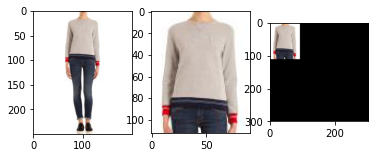

Original shape: torch.Size([3, 300, 300])
RGB channel moved: torch.Size([300, 300, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/5_Box-Pleated_A-Line_Skirt/img_00000005.jpg
Modified name: img/Box-Pleated_A-Line_Skirt/img_00000005.jpg
Cropped shape: torch.Size([233, 299, 3])


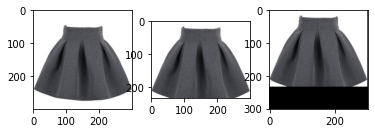

Original shape: torch.Size([3, 250, 200])
RGB channel moved: torch.Size([250, 200, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/7_Abstract_Print_Pleated_Dress/img_00000050.jpg
Modified name: img/Abstract_Print_Pleated_Dress/img_00000050.jpg
Cropped shape: torch.Size([136, 95, 3])


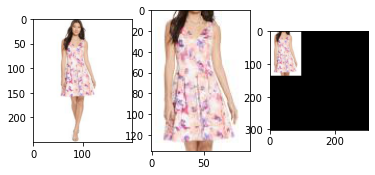

Original shape: torch.Size([3, 300, 213])
RGB channel moved: torch.Size([300, 213, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/3_Athletic_Marled_Knit_Joggers/img_00000007.jpg
Modified name: img/Athletic_Marled_Knit_Joggers/img_00000007.jpg
Cropped shape: torch.Size([161, 116, 3])


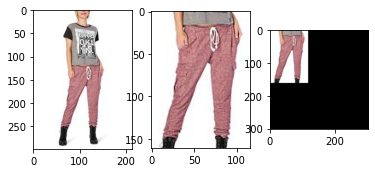

Original shape: torch.Size([3, 300, 236])
RGB channel moved: torch.Size([300, 236, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/7_Abstract_Print_Pleated_Dress/img_00000022.jpg
Modified name: img/Abstract_Print_Pleated_Dress/img_00000022.jpg
Cropped shape: torch.Size([244, 152, 3])


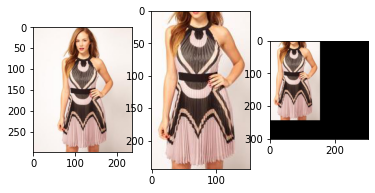

Original shape: torch.Size([3, 264, 300])
RGB channel moved: torch.Size([264, 300, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/0_Basic_Crew_Neck_Tee/img_00000005.jpg
Modified name: img/Basic_Crew_Neck_Tee/img_00000005.jpg
Cropped shape: torch.Size([258, 299, 3])


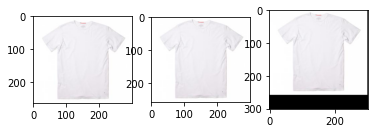

Original shape: torch.Size([3, 300, 211])
RGB channel moved: torch.Size([300, 211, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/5_Box-Pleated_A-Line_Skirt/img_00000003.jpg
Modified name: img/Box-Pleated_A-Line_Skirt/img_00000003.jpg
Cropped shape: torch.Size([161, 149, 3])


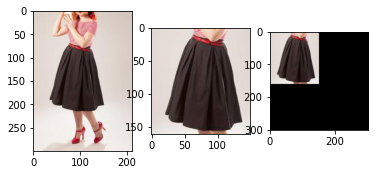

Original shape: torch.Size([3, 300, 300])
RGB channel moved: torch.Size([300, 300, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/0_Basic_Crew_Neck_Tee/img_00000062.jpg
Modified name: img/Basic_Crew_Neck_Tee/img_00000062.jpg
Cropped shape: torch.Size([254, 209, 3])


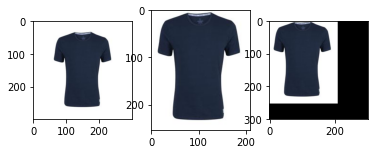

Original shape: torch.Size([3, 300, 229])
RGB channel moved: torch.Size([300, 229, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/2_Acid_Wash_Ankle_Jeans/img_00000004.jpg
Modified name: img/Acid_Wash_Ankle_Jeans/img_00000004.jpg
Cropped shape: torch.Size([295, 106, 3])


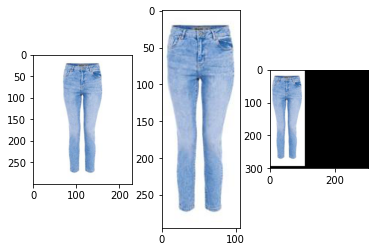

Original shape: torch.Size([3, 300, 300])
RGB channel moved: torch.Size([300, 300, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/6_Boxy_Turtleneck_Sweater/img_00000046.jpg
Modified name: img/Boxy_Turtleneck_Sweater/img_00000046.jpg
Cropped shape: torch.Size([218, 149, 3])


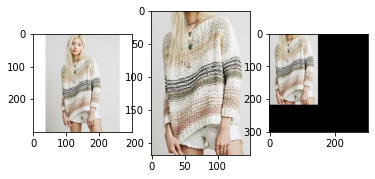

Original shape: torch.Size([3, 300, 240])
RGB channel moved: torch.Size([300, 240, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/1_Contrast-Trimmed_Sweater/img_00000002.jpg
Modified name: img/Contrast-Trimmed_Sweater/img_00000002.jpg
Cropped shape: torch.Size([265, 236, 3])


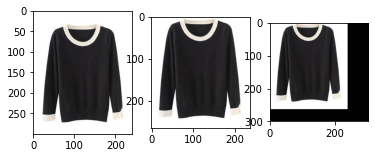

Original shape: torch.Size([3, 170, 214])
RGB channel moved: torch.Size([170, 214, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/4_Button_Fly_Denim_Shorts/img_00000003.jpg
Modified name: img/Button_Fly_Denim_Shorts/img_00000003.jpg
Cropped shape: torch.Size([169, 213, 3])


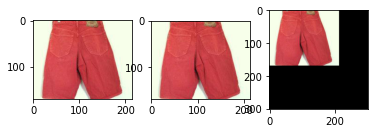

Original shape: torch.Size([3, 300, 240])
RGB channel moved: torch.Size([300, 240, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/8_Classic_Double-Breasted_Trench_Coat/img_00000037.jpg
Modified name: img/Classic_Double-Breasted_Trench_Coat/img_00000037.jpg
Cropped shape: torch.Size([166, 95, 3])


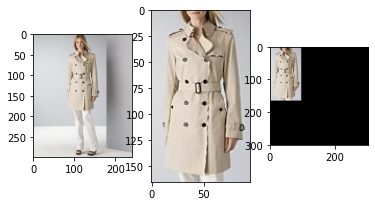

Original shape: torch.Size([3, 292, 199])
RGB channel moved: torch.Size([292, 199, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/3_Athletic_Marled_Knit_Joggers/img_00000003.jpg
Modified name: img/Athletic_Marled_Knit_Joggers/img_00000003.jpg
Cropped shape: torch.Size([167, 82, 3])


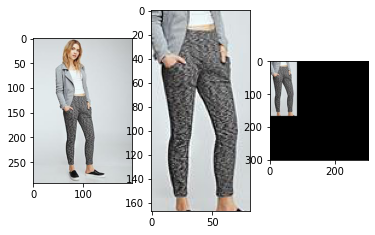

Original shape: torch.Size([3, 300, 236])
RGB channel moved: torch.Size([300, 236, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/2_Acid_Wash_Ankle_Jeans/img_00000003.jpg
Modified name: img/Acid_Wash_Ankle_Jeans/img_00000003.jpg
Cropped shape: torch.Size([276, 70, 3])


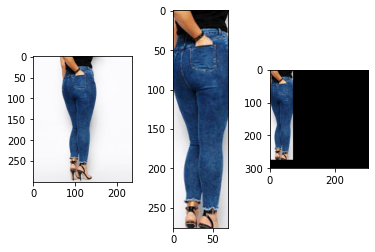

Original shape: torch.Size([3, 300, 205])
RGB channel moved: torch.Size([300, 205, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/4_Button_Fly_Denim_Shorts/img_00000004.jpg
Modified name: img/Button_Fly_Denim_Shorts/img_00000004.jpg
Cropped shape: torch.Size([66, 36, 3])


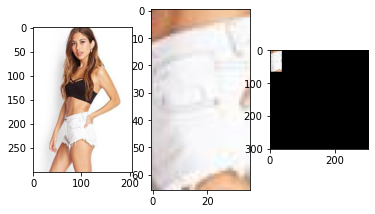

Original shape: torch.Size([3, 300, 205])
RGB channel moved: torch.Size([300, 205, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/7_Abstract_Print_Pleated_Dress/img_00000042.jpg
Modified name: img/Abstract_Print_Pleated_Dress/img_00000042.jpg
Cropped shape: torch.Size([155, 94, 3])


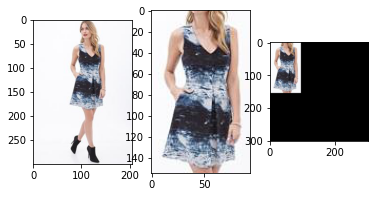

Original shape: torch.Size([3, 173, 236])
RGB channel moved: torch.Size([173, 236, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/4_Button_Fly_Denim_Shorts/img_00000005.jpg
Modified name: img/Button_Fly_Denim_Shorts/img_00000005.jpg
Cropped shape: torch.Size([133, 235, 3])


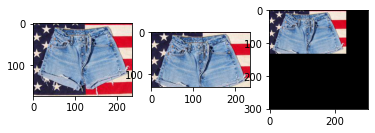

Original shape: torch.Size([3, 243, 300])
RGB channel moved: torch.Size([243, 300, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/2_Acid_Wash_Ankle_Jeans/img_00000006.jpg
Modified name: img/Acid_Wash_Ankle_Jeans/img_00000006.jpg
Cropped shape: torch.Size([145, 31, 3])


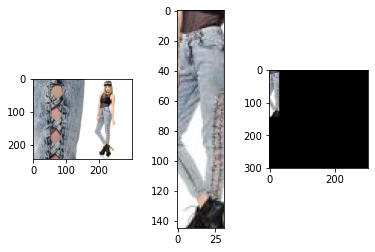

Original shape: torch.Size([3, 300, 205])
RGB channel moved: torch.Size([300, 205, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/5_Box-Pleated_A-Line_Skirt/img_00000013.jpg
Modified name: img/Box-Pleated_A-Line_Skirt/img_00000013.jpg
Cropped shape: torch.Size([122, 157, 3])


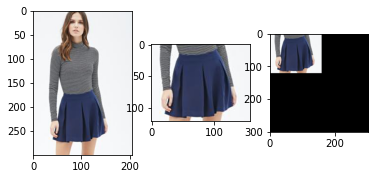

Original shape: torch.Size([3, 300, 226])
RGB channel moved: torch.Size([300, 226, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/1_Contrast-Trimmed_Sweater/img_00000005.jpg
Modified name: img/Contrast-Trimmed_Sweater/img_00000005.jpg
Cropped shape: torch.Size([270, 197, 3])


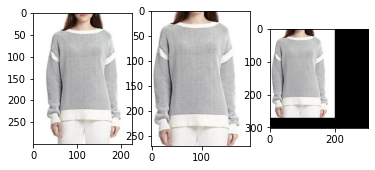

Original shape: torch.Size([3, 300, 201])
RGB channel moved: torch.Size([300, 201, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/8_Classic_Double-Breasted_Trench_Coat/img_00000035.jpg
Modified name: img/Classic_Double-Breasted_Trench_Coat/img_00000035.jpg
Cropped shape: torch.Size([229, 167, 3])


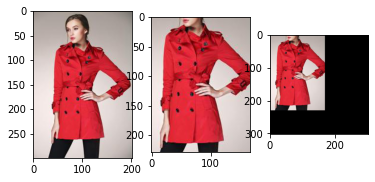

Original shape: torch.Size([3, 300, 196])
RGB channel moved: torch.Size([300, 196, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/8_Classic_Double-Breasted_Trench_Coat/img_00000003.jpg
Modified name: img/Classic_Double-Breasted_Trench_Coat/img_00000003.jpg
Cropped shape: torch.Size([253, 158, 3])


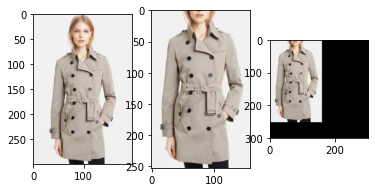

Original shape: torch.Size([3, 300, 196])
RGB channel moved: torch.Size([300, 196, 3])
Name: /content/gdrive/My Drive/Colab Notebooks/Project/Clothes/7_Abstract_Print_Pleated_Dress/img_00000024.jpg
Modified name: img/Abstract_Print_Pleated_Dress/img_00000024.jpg
Cropped shape: torch.Size([169, 124, 3])


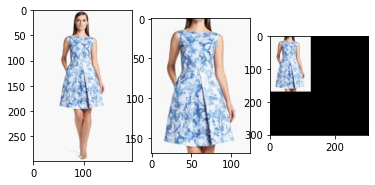

In [ ]:
processed_imgs = []

for images, labels, fname in dataloader:
  img = images[0] # batch size 1
  filename = fname[0]
  processed_img = crop_image(img, filename, max) # crop image
  processed_imgs.append((processed_img, labels[0])) # add cropped image + label to appropriate class list

In [ ]:
# Save processed images
torch.save(processed_imgs, "imgs.pt")

In [ ]:
clothing_images = torch.load("imgs.pt")
print(type(clothing_images))

<class 'list'>


torch.utils.data.dataloader.DataLoader
<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>


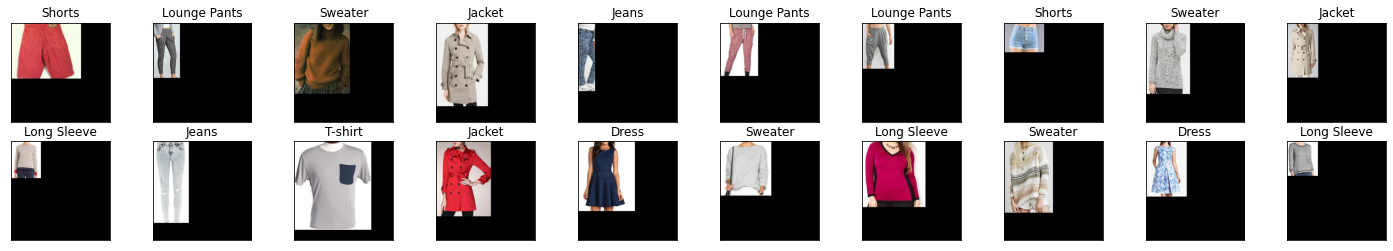

In [ ]:
# test a different batch size
dataloader_32 = torch.utils.data.DataLoader(clothing_images, batch_size=32, shuffle=True)

# obtain one batch of training images
print(type(dataloader_32))
dataiter = iter(dataloader_32)
print(type(dataiter))
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
classes = ["T-shirt", "Long Sleeve", "Jeans", "Lounge Pants", "Shorts", "Skirt", "Sweater", "Dress", "Jacket"]
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(images[idx])
    ax.set_title(classes[labels[idx]])